In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

## Overview
- Create features to prepare for using some classification algorithm.
- PK is `customer_unique_id`
- Row count should be 96096. (the number of `customer_unique_id`)

## Features
We create the following features in this notebook.

fo = first order that customer made

In [2]:
# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)
description_json_df

,column,source,description
0,customer_unique_id,df_customers,PK
1,customer_zip_code_prefix,df_customers,
2,customer_city,df_customers,
3,customer_state,df_customers,
4,customer_in_sao_paulo,Calculated,"1:in Sao Paulo, 0:non-Sao Paulo"
5,fo_order_id,df_orders,FK
6,fo_customer_id,df_orders,FK (first order's customer_id)
7,fo_order_status,df_orders,
8,fo_order_purchase_timestamp,df_orders,
9,fo_order_approved_at,df_orders,


In [3]:
df_customers = pd.read_csv('../datasets/olist_customers_dataset.csv')
df_order_items = pd.read_csv('../datasets/olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('../datasets/olist_order_payments_dataset.csv')
df_orders = pd.read_csv('../datasets/olist_orders_dataset.csv')
df_order_reviews = pd.read_csv('../datasets/olist_order_reviews_dataset.csv')
df_products = pd.read_csv('../datasets/olist_products_dataset.csv')
df_product_category_name_translation = pd.read_csv('../datasets/product_category_name_translation.csv')


In [4]:
## Merge 2 datasets
merged_df = pd.merge(df_orders, df_customers, on='customer_id')
    ## Memo: 'customer_id' is foreign key, while 'customer_unique_id' is primary key

print(f"df_orders: {df_orders.shape}")
print(f"df_customers: {df_customers.shape}")
print(f"df: {merged_df.shape}")

df_orders: (99441, 8)
df_customers: (99441, 5)
df: (99441, 12)


In [5]:
## datatypes for each column
merged_df.dtypes

## some data objects should be converted to datetime

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
customer_unique_id               object
customer_zip_code_prefix          int64
customer_city                    object
customer_state                   object
dtype: object

In [6]:
## Convert data object to datetime
df_columns = [
  'order_purchase_timestamp',
  'order_approved_at',
  'order_delivered_carrier_date',
  'order_delivered_customer_date',
  'order_estimated_delivery_date'
]

for col in df_columns:
  merged_df[col] = pd.to_datetime(merged_df[col], format='%Y-%m-%d %H:%M:%S')

### Check the frequecy distribution

In [7]:
df_frequency = merged_df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
df_frequency.columns = ["customer_unique_id", "frequency"]

repeater_num = df_frequency[df_frequency['frequency'] > 1].shape[0]
repeater_ratio = repeater_num / df_frequency.shape[0] * 100
print(f"{repeater_num} customers have ordered more than once.")
print(f"Only {repeater_ratio}% of customers have ordered more than once.")
df_frequency.describe()

2997 customers have ordered more than once.
Only 3.1187562437562435% of customers have ordered more than once.


,frequency
count,96096.000000
mean,1.034809
std,0.214384
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,17.000000


In [8]:
## Create label, called repeater
df_frequency['repeater'] = df_frequency['frequency'].apply(lambda x: 1 if x > 1 else 0)
df_frequency['repeater'] = df_frequency['repeater'].astype('int8')
    ## 1: repeater, 0: non-repeater

## get first_purchase_df
idx = merged_df.groupby('customer_unique_id')['order_purchase_timestamp'].idxmin()
first_purchase_df = merged_df.loc[idx]

## Merge
print(f"df_frequency: {df_frequency.shape}")
print(f"first_purchase_df: {first_purchase_df.shape}")
df = pd.merge(df_frequency, first_purchase_df, on='customer_unique_id', how='inner')
print(f"df: {df.shape}")
DF_ROW_COUNT = df.shape[0]

df.head()

df.rename({
    'order_id': 'fo_order_id',
    'customer_id': 'fo_customer_id',
    'order_status': 'fo_order_status',
    'order_purchase_timestamp': 'fo_order_purchase_timestamp',
    'order_approved_at': 'fo_order_approved_at',
    'order_delivered_carrier_date': 'fo_order_delivered_carrier_date',
    'order_delivered_customer_date': 'fo_order_delivered_customer_date',
    'order_estimated_delivery_date': 'fo_order_estimated_delivery_date'
}, axis=1, inplace=True)

df_frequency: (96096, 3)
first_purchase_df: (96096, 12)
df: (96096, 14)


In [9]:
## Check whether merge was successful as expected

def test_merge_results(before_df_shape, after_df, added_columns_num):
  after_df_shape = after_df.shape
  print(f"after_df_shape: {after_df_shape}")

  if after_df_shape[0] != DF_ROW_COUNT:
    raise ValueError(f"Error: Row count changed after merge. Row count should be {DF_ROW_COUNT}, but we got {after_df_shape[0]}")

  expected_cols_after = before_df_shape[1] + added_columns_num
  if after_df_shape[1] != expected_cols_after:
    raise ValueError(f"Error: Column count after merge is incorrect. Expected: {expected_cols_after}, Got: {after_df_shape[1]}")

  print("Merge test passed successfully.")
  return True


In [10]:
print(f"df: {df.shape}")
df.head()

df: (96096, 14)


,customer_unique_id,frequency,repeater,fo_order_id,fo_customer_id,fo_order_status,fo_order_purchase_timestamp,fo_order_approved_at,fo_order_delivered_carrier_date,fo_order_delivered_customer_date,fo_order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0,e22acc9c116caa3f2b7121bbb380d08e,fadbb3709178fc513abc1b2670aa1ad2,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21,7787,cajamar,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,3594e05a005ac4d06a72673270ef9ec9,4cb282e167ae9234755102258dd52ee8,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15,6053,osasco,SP
2,0000f46a3911fa3c0805444483337064,1,0,b33ec3b699337181488304f362a6b734,9b3932a6253894a02c1df9d19004239f,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,2017-04-07,88115,sao jose,SC
3,0000f6ccb0745a6a4b88665a16c9f078,1,0,41272756ecddd9a9ed0180413cc22fb6,914991f0c02ef0843c0e7010c819d642,delivered,2017-10-12 20:29:41,2017-10-12 20:49:17,2017-10-13 20:08:19,2017-11-01 21:23:05,2017-11-13,66812,belem,PA
4,0004aac84e0df4da2b147fca70cf8255,1,0,d957021f1127559cd947b62533f484f7,47227568b10f5f58a524a75507e6992c,delivered,2017-11-14 19:45:42,2017-11-14 20:06:52,2017-11-16 19:52:10,2017-11-27 23:08:56,2017-12-05,18040,sorocaba,SP


## Feature Engineering
Let's get started

### Recency


In [11]:
## Get the latest purchase date for each customer
df_latest_purchase = merged_df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
df_latest_purchase.columns = ['customer_unique_id', 'latest_purchase_date']
## Get Recency
df_latest_purchase['recency'] = (
    df_latest_purchase['latest_purchase_date'].max() - df_latest_purchase['latest_purchase_date']
).dt.days
df_latest_purchase.drop('latest_purchase_date', axis=1, inplace=True)

## Merge
df_shape = df.shape
df = pd.merge(
    df,
    df_latest_purchase,
    on='customer_unique_id', how='inner'
)
test_merge_results(df_shape, df, 1)

after_df_shape: (96096, 15)
Merge test passed successfully.


True

### Monetary

In [12]:
payment_values_per_order = df_order_payments.groupby('order_id')['payment_value'].sum().reset_index()

df_tmp = pd.merge(
    merged_df,
    payment_values_per_order,
    on='order_id', how='inner'
)
total_payment_per_customer = df_tmp.groupby('customer_unique_id')['payment_value'].sum().reset_index()

df_shape = df.shape
df = pd.merge(
    df,
    total_payment_per_customer,
    on='customer_unique_id', how='left'
)
test_merge_results(df_shape, df, 1)

df.rename({'payment_value': 'monetary'}, axis=1, inplace=True)
df['monetary'].fillna(0, inplace=True)

after_df_shape: (96096, 16)
Merge test passed successfully.


### RFM Score

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['recency', 'frequency', 'monetary']])

clusters_mean_monetary = df.groupby('cluster')['monetary'].mean().sort_values(ascending=True)
cluster_mapping = {old: new for new, old in enumerate(clusters_mean_monetary.index)}

df['rfm_score'] = df['cluster'].map(cluster_mapping)
df.drop(columns=['cluster'], inplace=True)


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Payment value of first order

In [14]:
df_shape = df.shape
df = pd.merge(
    df,
    payment_values_per_order,
    left_on='fo_order_id', right_on='order_id',
    how='left'
)
df.drop('order_id', axis=1, inplace=True)
test_merge_results(df_shape, df, 1)
df.rename({'payment_value': 'fo_payment_value'}, axis=1, inplace=True)

after_df_shape: (96096, 18)
Merge test passed successfully.


### Create some columns from order_purchase_timestamp

In [15]:
## Only meaningful features will be added to the df,
## since creating meaningless columns is expected to result in poor accuracy of the clustering model,
df_tmp = df.copy()
df_tmp['order_purchase_year'] = df_tmp['fo_order_purchase_timestamp'].dt.year
    ## Refected. because the time span is too short. 2016/09 ~ 2018/10.
df_tmp['order_purchase_month'] = df_tmp['fo_order_purchase_timestamp'].dt.month
    ## Refected. because the time span is too short. 2016/09 ~ 2018/10.
df_tmp['order_purchase_day'] = df_tmp['fo_order_purchase_timestamp'].dt.day
    ## Refected. because of the chart below
df_tmp['order_purchase_hour'] = df_tmp['fo_order_purchase_timestamp'].dt.hour
    ## Accepted: The chart below shows that there is a difference in the number of orders between time of day.
df_tmp['order_purchase_day_of_week'] = df_tmp['fo_order_purchase_timestamp'].dt.dayofweek
    ## Accepted: Our EDA shows that there is a difference in the number of orders between weekdays and weekend.
    ## Reference: https://dat490-marketing.streamlit.app/EDA_Overview#total-order-per-weekday
    ## We create the column, called 'weekdays' for boolean label.

<Axes: xlabel='order_purchase_day'>

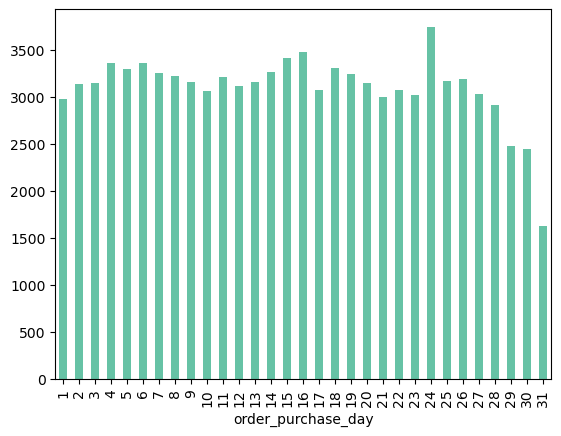

In [16]:
df_tmp.groupby('order_purchase_day')['customer_unique_id'].count().plot(kind='bar')

## 'order_purchase_day' is not meaningful.

<Axes: xlabel='order_purchase_hour'>

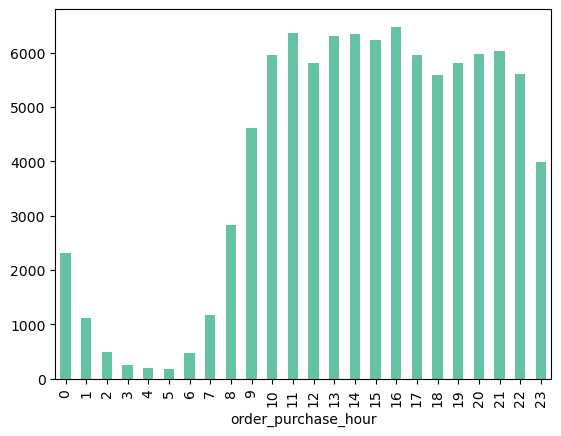

In [17]:
df_tmp.groupby('order_purchase_hour')['customer_unique_id'].count().plot(kind='bar')

## we cancategorize the time of day into 2 categories: is_daytime (9-23) or not (0-8)

In [18]:
## add two columns
df_tmp["is_daytime"] = df_tmp["order_purchase_hour"].apply(lambda x: 1 if 9 <= x <= 23 else 0)
df_tmp['is_weekday'] = df_tmp['order_purchase_day_of_week'].apply(lambda x: 1 if x < 5 else 0)
df_tmp["is_daytime"] = df_tmp["is_daytime"].astype('int8')
df_tmp['is_weekday'] = df_tmp['is_weekday'].astype('int8')

## merge
df_shape = df.shape
df = pd.merge(
    df, df_tmp[['customer_unique_id', 'is_daytime', 'is_weekday']],
    on='customer_unique_id', how='inner'
)
test_merge_results(df_shape, df, 2)

df.rename({
    'is_daytime': 'fo_is_daytime',
    'is_weekday': 'fo_is_weekday'
}, axis=1, inplace=True)


after_df_shape: (96096, 20)
Merge test passed successfully.


### The first delivery delay

In [19]:
df['fo_delivery_delay_days'] = (df['fo_order_delivered_customer_date'] - df['fo_order_estimated_delivery_date']).dt.days
    ## positive->delay, negative->ahead

df.groupby('repeater')['fo_delivery_delay_days'].describe()

,count,mean,std,min,25%,50%,75%,max
repeater,,,,,,,,
0,90377.0,-11.825420,10.207349,-147.0,-17.0,-12.0,-7.0,188.0
1,2874.0,-12.758525,9.593957,-78.0,-17.0,-13.0,-8.0,47.0


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


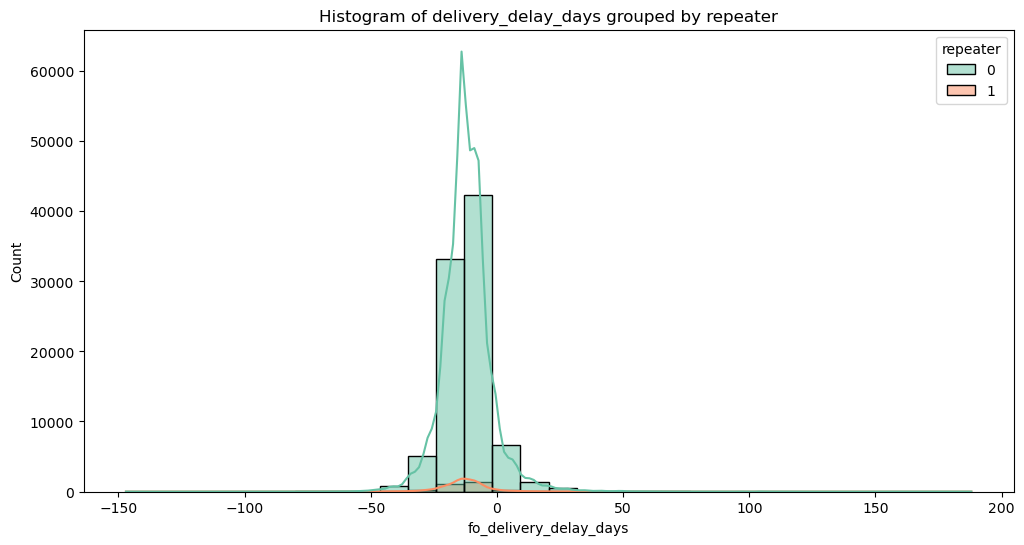

In [20]:
## histogram of delivery_delay_days grouped by repeater
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='fo_delivery_delay_days', hue='repeater', kde=True, bins=30)
plt.title('Histogram of delivery_delay_days grouped by repeater')
plt.show()


- There are some outliers, but the distribution is almost same.
- I'm surprised that the means are -11 days. It means that the delivery is faster than the estimated delivery date. Olist may have set an estimated delivery time with plenty of time to spare.
- If we do the same thing for each product category, we would see differences in results. I'll leave it out as it is not pertinent to the purpose of this file, but it would be interesting to see

### The first order's review score


In [21]:
## Merge with df_order_reviews

## An order can have multiple reviews, so we take the average of review scores
df_tmp = df_order_reviews.groupby('order_id')['review_score'].mean().reset_index()
df_shape = df.shape
df = pd.merge(
    df,
    df_tmp,
    left_on='fo_order_id', right_on="order_id",
    how='left'
)
df.drop('order_id', axis=1, inplace=True)
test_merge_results(df_shape, df, 1)

df.rename({
    'review_score': 'fo_review_score_mean',
}, axis=1, inplace=True)

## Check missing values of review_score grouped by repeater
print("Number of those who have not reviewed: ")
df.groupby('repeater')['fo_review_score_mean'].apply(lambda x: x.isnull().sum())

after_df_shape: (96096, 22)
Merge test passed successfully.
Number of those who have not reviewed: 


repeater
0    707
1     30
Name: fo_review_score_mean, dtype: int64

In [22]:
df.groupby('repeater')['fo_review_score_mean'].describe()

,count,mean,std,min,25%,50%,75%,max
repeater,,,,,,,,
0,92392.0,4.083979,1.347447,1.0,4.0,5.0,5.0,5.0
1,2967.0,4.107853,1.340784,1.0,4.0,5.0,5.0,5.0


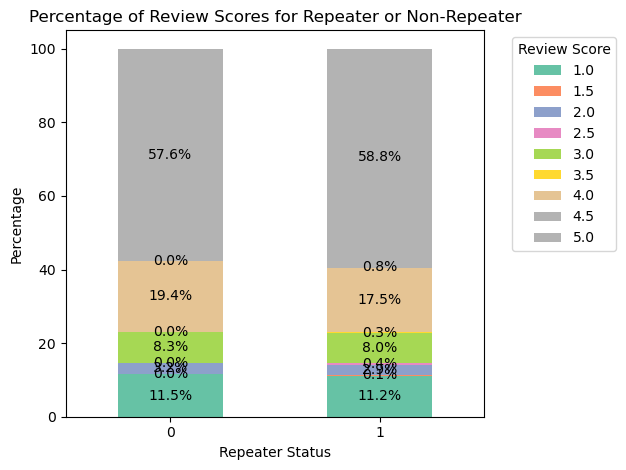

In [23]:
## histogram of review_score grouped by repeater
score_distribution = df.groupby(['repeater', 'fo_review_score_mean']).size().unstack(fill_value=0)
score_percentage = score_distribution.divide(score_distribution.sum(axis=1), axis=0) * 100

ax = score_percentage.plot(kind='bar', stacked=True)
plt.title('Percentage of Review Scores for Repeater or Non-Repeater')
plt.xlabel('Repeater Status')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Review Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width/2,
                y + height/2,
                f"{height:.1f}%",
                ha='center',
                va='center')
plt.show()

- There are no difference of distribution between repeaters and non-repeaters.
- Future work: emotional analysis of the review text

### Does Customer use promotion for the first order?

In [24]:
df_voucher = df_order_payments[df_order_payments['payment_type'] == 'voucher']
df_voucher = df_voucher[['order_id', 'payment_value']]
df_voucher.rename(columns={'payment_value': 'voucher_payment_value'}, inplace=True)
df_voucher.describe()

,voucher_payment_value
count,5775.000000
mean,65.703354
std,115.519185
min,0.000000
25%,18.035000
50%,39.280000
75%,80.000000
max,3184.340000


In [25]:
## Merge with df_voucher
## An order can have multiple voucher payments, so we sum them up
df_voucher = df_voucher.groupby('order_id')['voucher_payment_value'].sum().reset_index()
df_shape = df.shape
df = pd.merge(
    df, df_voucher,
    left_on='fo_order_id', right_on='order_id',
    how='left'
)
df['voucher_payment_value'].fillna(0, inplace=True)
df.drop('order_id', axis=1, inplace=True)
test_merge_results(df_shape, df, 1)

df.rename({
    'voucher_payment_value': 'fo_voucher_payment_value'
}, axis=1, inplace=True)

## Create a new column, called voucher_used
df['fo_voucher_used'] = df['fo_voucher_payment_value'].apply(lambda x: 0 if np.isnan(x) else 1)
df['fo_voucher_used'] = df['fo_voucher_used'].astype('int8')
    ## 1: used, 0: not used
df.groupby('repeater')['fo_voucher_used'].value_counts().unstack(fill_value=0)


after_df_shape: (96096, 23)
Merge test passed successfully.


fo_voucher_used,1
repeater,
0,93099
1,2997


In [26]:
## Calculate the percentage of voucher_used grouped by repeater
voucher_counts = df.groupby('repeater')['fo_voucher_used'].value_counts().unstack(fill_value=0)
voucher_percentages = voucher_counts.div(voucher_counts.sum(axis=1), axis=0) * 100
voucher_percentages

fo_voucher_used,1
repeater,
0,100.0
1,100.0


In [27]:
## How much money is spent on vouchers?
df.groupby('repeater')['fo_voucher_payment_value'].describe()

,count,mean,std,min,25%,50%,75%,max
repeater,,,,,,,,
0,93099.0,3.617372,30.678880,0.0,0.0,0.0,0.0,2266.61
1,2997.0,4.099366,29.223628,0.0,0.0,0.0,0.0,871.44


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


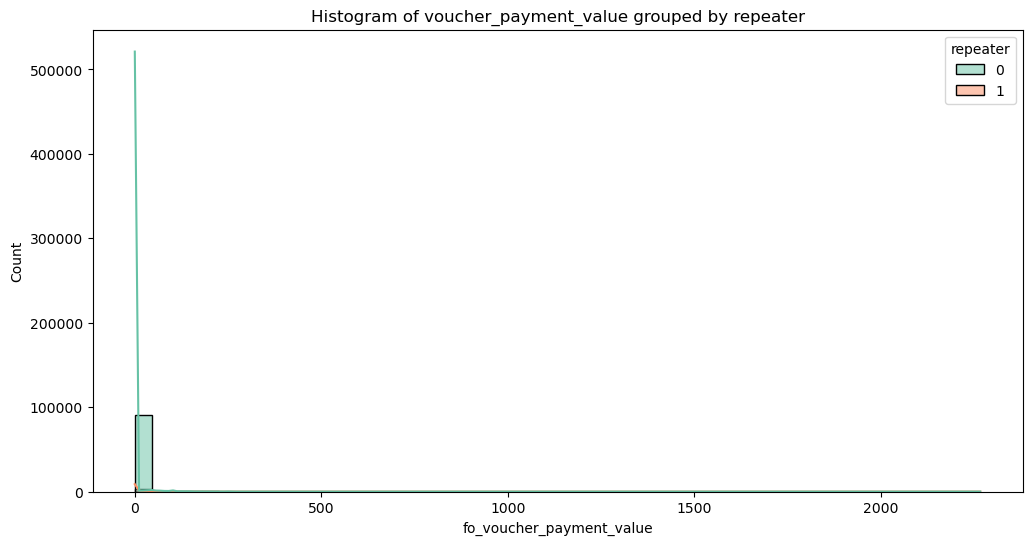

In [28]:
## histogram of voucher_payment_value grouped by repeater
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='fo_voucher_payment_value', hue='repeater', kde=True, bins=50)
plt.title('Histogram of voucher_payment_value grouped by repeater')
plt.show()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


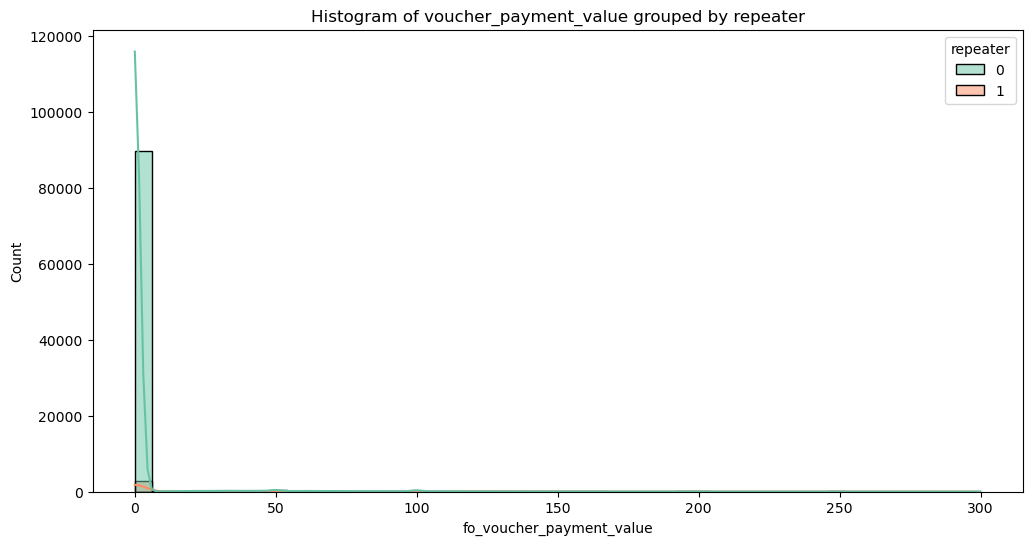

In [29]:
## Remove outliers
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['fo_voucher_payment_value'] < 300], x='fo_voucher_payment_value', hue='repeater', kde=True, bins=50)
plt.title('Histogram of voucher_payment_value grouped by repeater')
plt.show()

- More than 90% of the customers don't use voucher for the first order.
- There is no big difference in the distribution of repeaters and non-repeaters.

### Product category of the first order
- If a user buy multiple products, I choose the first product category.
- I wanted to choose the category those product is most expensive, but we don't have the product price.

In [30]:
## Before that, let's check the average number of products for each order.
average_num = df_order_items.groupby('order_id')['order_item_id'].count().mean()
print(f"The average number of products for each order is {average_num:.2f}.")

df_average_num = df_order_items.groupby('order_id')['order_item_id'].count().reset_index()
df_average_num.columns = ['order_id', 'num_products']
df_average_num.describe()

one_product_percentage = (df_average_num['num_products'] == 1).mean() * 100
print(f"{one_product_percentage:.2f} % of orders have only one product.")

The average number of products for each order is 1.14.
90.06 % of orders have only one product.


In [31]:
## Replace Portuguese product category names with English ones
product_category_name_EN = pd.merge(
    df_products[['product_id', 'product_category_name']],
    df_product_category_name_translation,
    on='product_category_name',
    how='left'
)
product_category_name_EN.drop('product_category_name', axis=1, inplace=True)

## Merge df_order_items with product_category_name_EN
print(f"df_order_items: {df_order_items.shape}")
print(f"product_category_name_EN: {product_category_name_EN.shape}")
df_tmp = pd.merge(
    df_order_items[['order_id', 'product_id']],
    product_category_name_EN,
    on='product_id', how='inner'
)
print(f"df_tmp: {df_order_items.shape}")

## Get the first product category name for each order
df_order_product_category = df_tmp. \
    groupby('order_id')['product_category_name_english'].first().reset_index()
## Check order_id is unique
print("df_order_product_category's order_id is unique?: ", df_order_product_category['order_id'].is_unique)
print(f"df_order_product_category: {df_order_product_category.shape}")

df_shape = df.shape
df = pd.merge(
    df, df_order_product_category,
    left_on='fo_order_id', right_on='order_id',
    how='left'
)
df.drop('order_id', axis=1, inplace=True)
test_merge_results(df_shape, df, 1)

df.rename({
    'product_category_name_english': 'fo_product_category_name'
}, axis=1, inplace=True)


df_order_items: (112650, 7)
product_category_name_EN: (32951, 2)
df_tmp: (112650, 7)
df_order_product_category's order_id is unique?:  True
df_order_product_category: (98666, 2)
after_df_shape: (96096, 25)
Merge test passed successfully.


### "is San Paulo" or not

In [32]:
df['customer_in_sao_paulo'] = df['customer_state'].apply(lambda x: 1 if x == 'SP' else 0)
df['customer_in_sao_paulo'] = df['customer_in_sao_paulo'].astype('int8')

df['customer_in_sao_paulo'].value_counts()

customer_in_sao_paulo
0    55805
1    40291
Name: count, dtype: int64

## Finally see the result

In [33]:
print(f"df: {df.shape}")
df.head()

df: (96096, 26)


,customer_unique_id,frequency,repeater,fo_order_id,fo_customer_id,fo_order_status,fo_order_purchase_timestamp,fo_order_approved_at,fo_order_delivered_carrier_date,fo_order_delivered_customer_date,...,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,fo_product_category_name,customer_in_sao_paulo
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0,e22acc9c116caa3f2b7121bbb380d08e,fadbb3709178fc513abc1b2670aa1ad2,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,...,0,141.90,1,1,-5.0,5.0,0.0,1,bed_bath_table,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,3594e05a005ac4d06a72673270ef9ec9,4cb282e167ae9234755102258dd52ee8,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,...,0,27.19,1,1,-5.0,4.0,0.0,1,health_beauty,1
2,0000f46a3911fa3c0805444483337064,1,0,b33ec3b699337181488304f362a6b734,9b3932a6253894a02c1df9d19004239f,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,...,1,86.22,1,1,-2.0,3.0,0.0,1,stationery,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,0,41272756ecddd9a9ed0180413cc22fb6,914991f0c02ef0843c0e7010c819d642,delivered,2017-10-12 20:29:41,2017-10-12 20:49:17,2017-10-13 20:08:19,2017-11-01 21:23:05,...,1,43.62,1,1,-12.0,4.0,0.0,1,telephony,0
4,0004aac84e0df4da2b147fca70cf8255,1,0,d957021f1127559cd947b62533f484f7,47227568b10f5f58a524a75507e6992c,delivered,2017-11-14 19:45:42,2017-11-14 20:06:52,2017-11-16 19:52:10,2017-11-27 23:08:56,...,1,196.89,1,1,-8.0,5.0,0.0,1,telephony,1


In [34]:
from utils import get_df_description

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df, description_json_df)
df_description

,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int8,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,datetime64[ns],0,df_orders,
7,fo_order_approved_at,datetime64[ns],0,df_orders,
8,fo_order_delivered_carrier_date,datetime64[ns],0,df_orders,
9,fo_order_delivered_customer_date,datetime64[ns],0,df_orders,


In [35]:
# drop the row where the # of missing values of monetary is greater than 0.
df = df[df['monetary'].notna()]

In [36]:
def save_df(df, file_name):
  df.to_csv(f'../datasets/{file_name}.csv', index=False)

save_df(df, 'df_train')

# Sampling 5000 data and save it
# to avoid multicollinearity, we drop the following columns
df_sample_5000 = df.sample(5000, random_state=42)
df_sample_5000.drop(columns=['frequency', 'monetary', 'fo_voucher_used'], inplace=True)
save_df(df_sample_5000, 'df_sample_5000')

In [37]:
df['fo_voucher_used'].value_counts()

fo_voucher_used
1    96096
Name: count, dtype: int64